# OneClassSVM - Train model on ASTRO data

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [100]:
# Load dataset
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})
print(df_astro.columns)

df_astro.head()

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


,E_peak,beta,sigma,beta_Rel,class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [101]:
X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

# === 2. SPLIT: Train / Val / Test ===
X_train, X_temp = train_test_split(X, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# === 3. SCALE THE DATA ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [102]:
# Define hyperparameter ranges
nu_values = [0.005, 0.01, 0.02, 0.05]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))  # 0.001 to 10

# Track results
results = []
best_score = np.inf
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        # Predict on validation set
        preds = model.predict(X_val_scaled)
        n_outliers = np.sum(preds == -1)  # -1 means "anomaly"
        
        results.append({'nu': nu, 'gamma': gamma, 'outliers': n_outliers})
        
        if n_outliers < best_score:
            best_score = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Show best hyperparameters
print(f"✅ Best Parameters: nu = {best_params['nu']}, gamma = {best_params['gamma']}")
print(f"🚨 Outliers on Validation Set: {best_score}")


✅ Best Parameters: nu = 0.005, gamma = 0.1
🚨 Outliers on Validation Set: 4


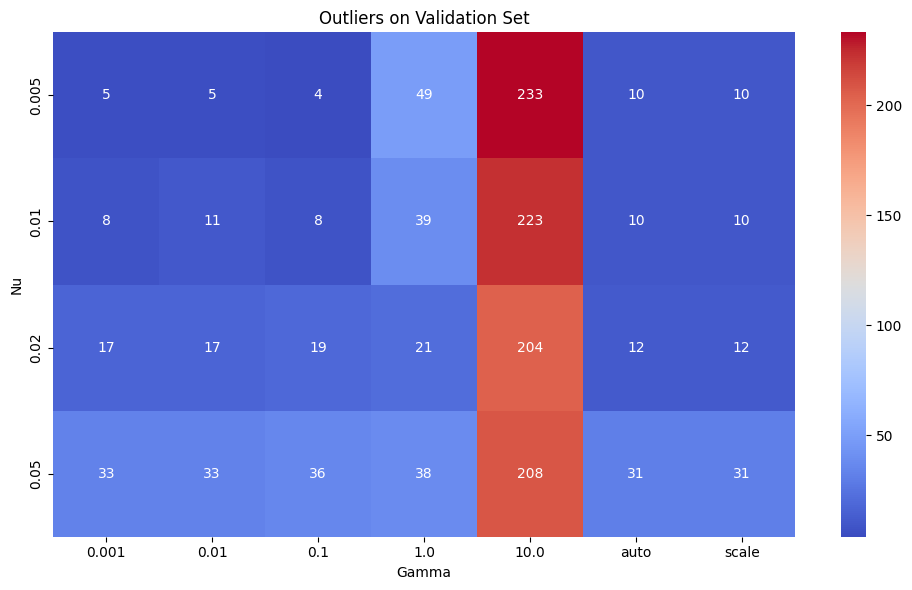

In [103]:
df_results = pd.DataFrame(results)
df_results['gamma_str'] = df_results['gamma'].astype(str)
heatmap_data = df_results.pivot(index='nu', columns='gamma_str', values='outliers')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title("Outliers on Validation Set")
plt.xlabel("Gamma")
plt.ylabel("Nu")
plt.tight_layout()
plt.show()


In [104]:
# Evaluate on the test set
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"🔍 Outliers on Final Test Set: {n_test_outliers}")

🔍 Outliers on Final Test Set: 6


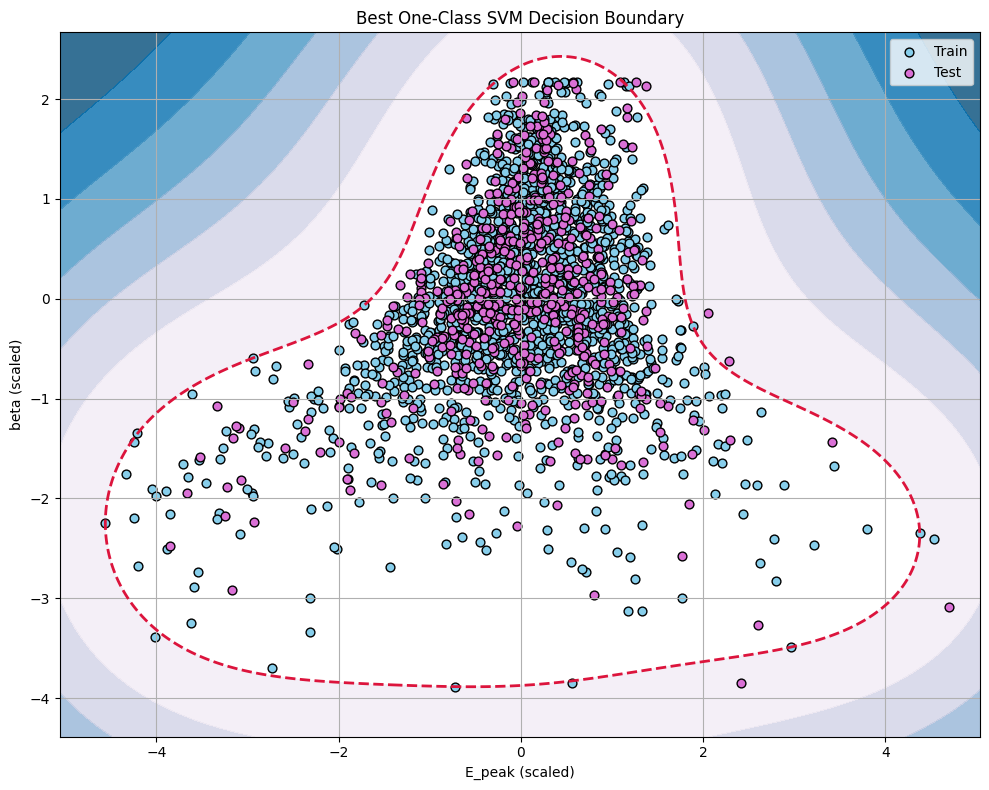

In [105]:
# Create meshgrid (with correct feature order: [beta, E_peak])
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Plot training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='skyblue', edgecolors='k', s=40, label='Train')
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0], c='orchid', edgecolors='k', s=40, label='Test')

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("Best One-Class SVM Decision Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Generate random 'noise' in data for testing Precision and Recall

In [106]:
rng = np.random.RandomState(42)
n_anomalies = 20

# Assuming 2 features (beta and E_peak), generate noise in [-5, 5] range
anomalies = rng.uniform(low=-5, high=5, size=(n_anomalies, 2))
anomalies_scaled = scaler.transform(anomalies)

# Combine normal and fake data
X_eval = np.vstack([X_val_scaled, anomalies_scaled])
y_eval = np.hstack([np.ones(len(X_val_scaled)), -1 * np.ones(len(anomalies_scaled))])  # 1 = normal, -1 = fake anomaly

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict using best model
y_pred = best_model.predict(X_eval)

print(confusion_matrix(y_eval, y_pred, labels=[1, -1]))
print(classification_report(y_eval, y_pred, target_names=["Normal", "Anomaly"]))


[[562   4]
 [  3  17]]
              precision    recall  f1-score   support

      Normal       0.81      0.85      0.83        20
     Anomaly       0.99      0.99      0.99       566

    accuracy                           0.99       586
   macro avg       0.90      0.92      0.91       586
weighted avg       0.99      0.99      0.99       586



# Predict on UNIDs

In [108]:
# Load the full dataset
unids_path = "../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [109]:
# Apply log10 to columns
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

In [110]:
# Extraer y escalar
X_unids_log = df_unids_log[["beta", "E_peak"]].values
X_unids_scaled = scaler.transform(X_unids_log)
# Predict using the best model
preds_non_astro = best_model.predict(X_unids_scaled)

In [111]:
n_outliers = np.sum(preds_non_astro == -1)
n_normals = np.sum(preds_non_astro == 1)

print(f"🚀 Predicted ASTRO-like: {n_normals}")
print(f"❗ Predicted not ASTRO-like (anomalies): {n_outliers}")


🚀 Predicted ASTRO-like: 1117
❗ Predicted not ASTRO-like (anomalies): 8


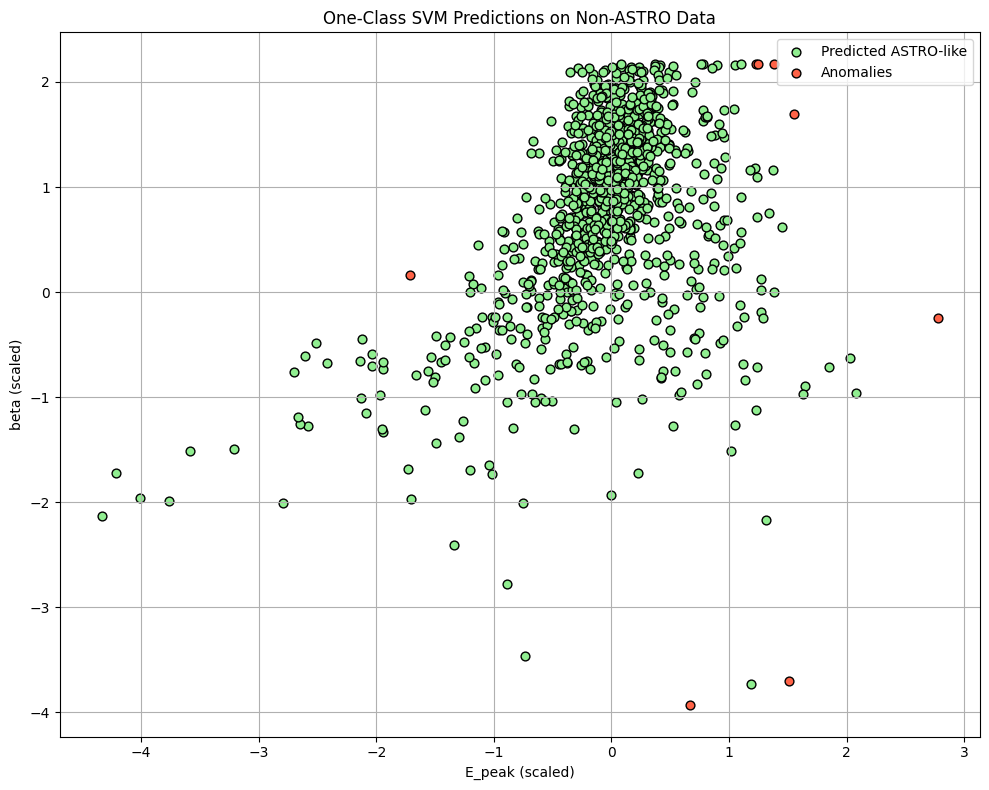

In [112]:
plt.figure(figsize=(10, 8))
plt.scatter(
    X_unids_scaled[preds_non_astro == 1, 1],  # E_peak
    X_unids_scaled[preds_non_astro == 1, 0],  # beta
    c='lightgreen', edgecolors='k', label='Predicted ASTRO-like', s=40
)

plt.scatter(
    X_unids_scaled[preds_non_astro == -1, 1],
    X_unids_scaled[preds_non_astro == -1, 0],
    c='tomato', edgecolors='k', label='Anomalies', s=40
)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("One-Class SVM Predictions on Non-ASTRO Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


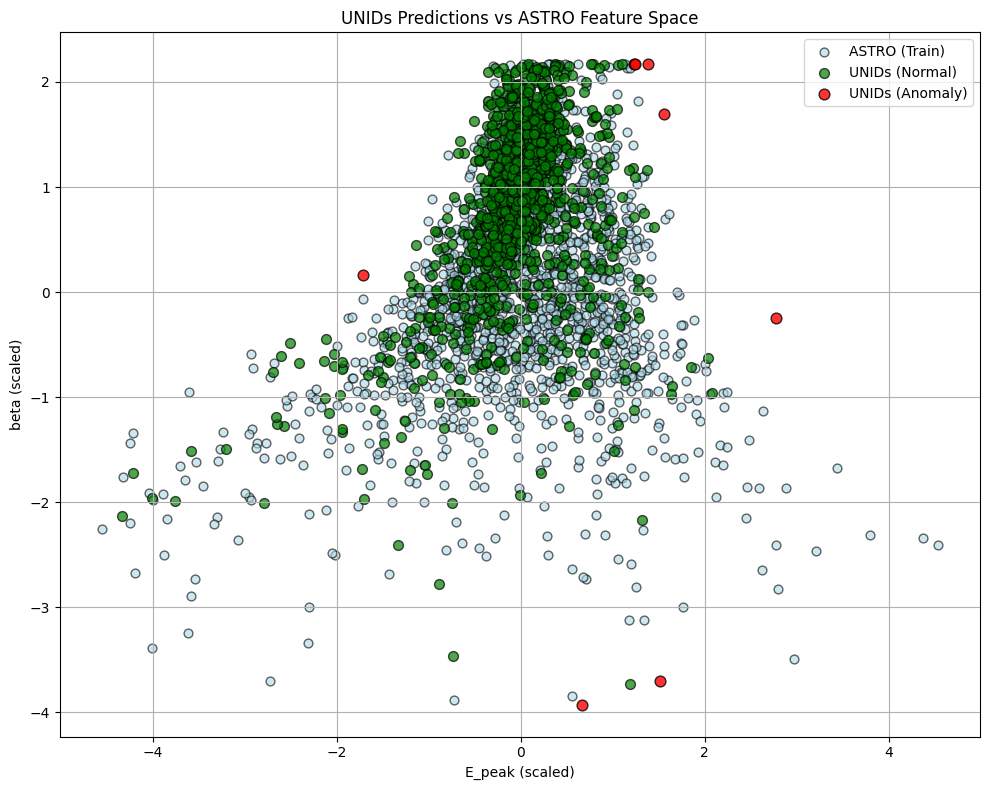

In [113]:
plt.figure(figsize=(10, 8))

# ASTRO data (train set)
plt.scatter(
    X_train_scaled[:, 1], X_train_scaled[:, 0],
    c='lightblue', edgecolors='k', s=40, alpha=0.6, label='ASTRO (Train)'
)

# Non-ASTRO predicted as normal
plt.scatter(
    X_unids_scaled[preds_non_astro == 1, 1],
    X_unids_scaled[preds_non_astro == 1, 0],
    c='green', edgecolors='k', s=50, alpha=0.7, label='UNIDs (Normal)'
)

# Non-ASTRO predicted as anomalies
plt.scatter(
    X_unids_scaled[preds_non_astro == -1, 1],
    X_unids_scaled[preds_non_astro == -1, 0],
    c='red', edgecolors='k', s=60, alpha=0.8, label='UNIDs (Anomaly)'
)

plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.title("UNIDs Predictions vs ASTRO Feature Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Lower scores = more anomalous
scores = best_model.decision_function(X_unids_scaled)
# Sort by most anomalous
most_anomalous_idx = np.argsort(scores)[:10]

# Print identifiers of the most anomalous entries
print("🔍 Top 10 Most Anomalous UNID Sources:")
print(df_unids_log.iloc[most_anomalous_idx][['number', 'E_peak', 'beta', 'sigma_det']])


Top 10 Most Anomalous Non-ASTRO Sources:
[[-0.24583586  2.77951086]
 [ 2.16771517  1.38178492]
 [ 0.16268815 -1.71661427]
 [-3.9262774   0.66874501]
 [ 2.16791724  1.24658813]
 [ 2.16700759  1.23392974]
 [ 1.69873175  1.55333603]
 [-3.70084377  1.5142219 ]
 [ 2.09937024 -0.3554432 ]
 [-3.73509325  1.19091617]]
